In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Load the [Wine Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine)

In [2]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data

In [3]:
import pandas as pd
df = pd.DataFrame(X, columns=wine.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## Create a Spark DataFrame

In [4]:
df = sqlContext.createDataFrame(df)

In [5]:
df.printSchema()

root
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: double (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- od280/od315_of_diluted_wines: double (nullable = true)
 |-- proline: double (nullable = true)



## Normalize the dataset

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=df.columns, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='normFeatures', withMean=True)

df = assembler.transform(df)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In [7]:
df.printSchema()

root
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: double (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- od280/od315_of_diluted_wines: double (nullable = true)
 |-- proline: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- normFeatures: vector (nullable = true)



## Get the RDD

In [8]:
rdd = df.select('normFeatures').rdd

## Convert the RDD into a [`RowMatrix`](https://spark.apache.org/docs/2.2.0/api/java/org/apache/spark/mllib/linalg/distributed/RowMatrix.html)

In [9]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors

In [10]:
vectors = rdd.map(Vectors.dense)
matrix = RowMatrix(vectors)

## Get the PCs of the matrix

In [11]:
pc = matrix.computePrincipalComponents(2)

In [12]:
matrix_reduced = matrix.multiply(pc)

In [13]:
matrix_reduced.numCols()

2

In [14]:
import numpy as np
x_red = np.array(matrix_reduced.rows.collect())

In [15]:
import matplotlib.pyplot as plt

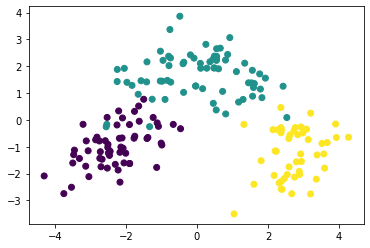

In [16]:
plt.scatter(x_red[:, 0], x_red[:, 1], c=wine.target)

## Verify with sklearn

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

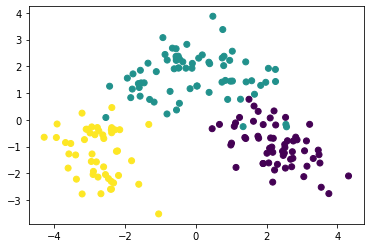

In [18]:
X = StandardScaler().fit_transform(wine.data)
pca = PCA()
x_red = pca.fit_transform(X)
plt.scatter(x_red[:, 0], x_red[:, 1], c=wine.target)